In [ ]:
import os, glob
import scipy
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
# 비전딥러닝 관련 : https://wikidocs.net/135874

In [ ]:
# Dataset - https://www.kaggle.com/datasets/daggysheep/find-a-car-park
# Dataset2 - https://www.kaggle.com/datasets/phylake1337/fire-dataset
os.environ['KAGGLE_USERNAME'] = 'leelang' # username
os.environ['KAGGLE_KEY'] = 'bc31229ab73924283c71cf48fff880a0' # key
!kaggle datasets download -d daggysheep/find-a-car-park

Dataset URL: https://www.kaggle.com/datasets/daggysheep/find-a-car-park
License(s): CC-BY-NC-SA-4.0
100% 4.99G/5.00G [01:03<00:00, 100MB/s]
100% 5.00G/5.00G [01:03<00:00, 85.1MB/s]


In [ ]:
!unzip -q ChestXRay2017.zip

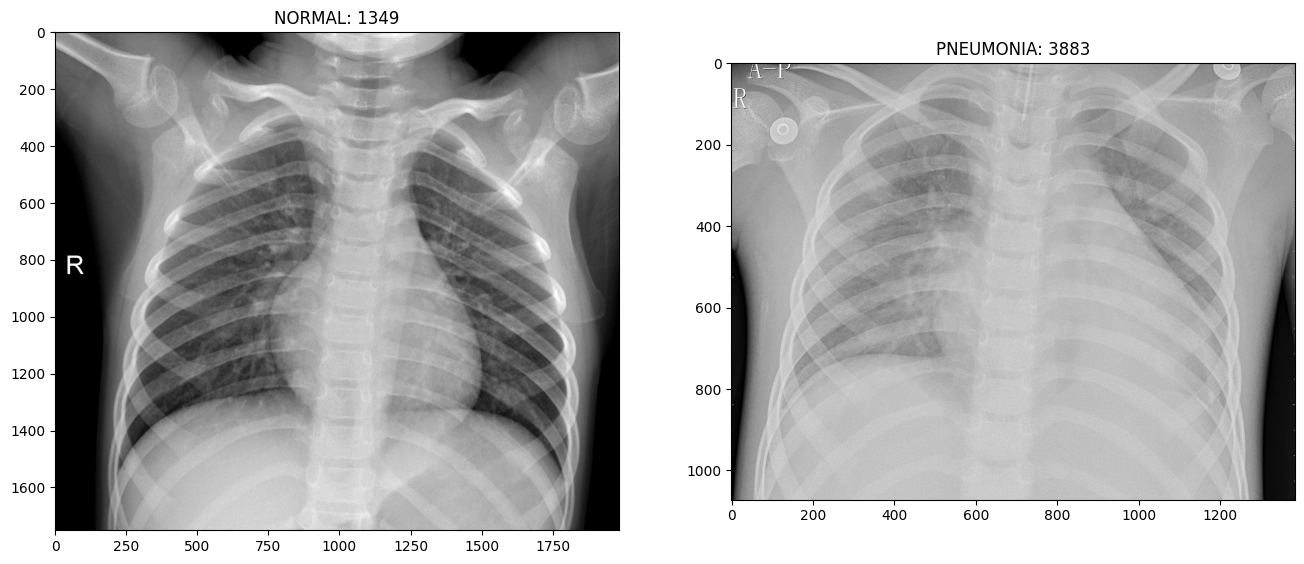

In [ ]:
BASE_PATH = '/content/chest_xray' # 변경된 BASE_PATH

train_normal_list = glob.glob(os.path.join(BASE_PATH, 'train/NORMAL/*.jpeg'))
train_pneumonia_list = glob.glob(os.path.join(BASE_PATH, 'train/PNEUMONIA/*.jpeg'))

if train_normal_list:
    normal_img = img_to_array(load_img(train_normal_list[0]), dtype=np.uint8)
else:
    normal_img = np.zeros((1, 1, 3), dtype=np.uint8) # 이미지가 없을 경우 빈 이미지 생성

if train_pneumonia_list:
    pneumonia_img = img_to_array(load_img(train_pneumonia_list[0]), dtype=np.uint8)
else:
    pneumonia_img = np.zeros((1, 1, 3), dtype=np.uint8) # 이미지가 없을 경우 빈 이미지 생성

plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.title(f'NORMAL: {len(train_normal_list)}')
plt.imshow(normal_img)
plt.subplot(1, 2, 2)
plt.title(f'PNEUMONIA: {len(train_pneumonia_list)}')
plt.imshow(pneumonia_img)
plt.show()

In [ ]:
import os

BASE_PATH = '/content/chest_xray'

for root, dirs, files in os.walk(BASE_PATH):
    print(f"\n📂 현재 경로: {root}")
    print(f"📁 포함된 폴더: {dirs}")
    print(f"🖼️ 포함된 파일 (샘플): {files[:5]}")



📂 현재 경로: /content/chest_xray
📁 포함된 폴더: ['test', 'train']
🖼️ 포함된 파일 (샘플): ['.DS_Store']

📂 현재 경로: /content/chest_xray/test
📁 포함된 폴더: ['PNEUMONIA', 'NORMAL']
🖼️ 포함된 파일 (샘플): ['.DS_Store']

📂 현재 경로: /content/chest_xray/test/PNEUMONIA
📁 포함된 폴더: []
🖼️ 포함된 파일 (샘플): ['person101_bacteria_485.jpeg', 'person15_virus_46.jpeg', 'person126_bacteria_600.jpeg', 'person133_bacteria_637.jpeg', 'person3_virus_17.jpeg']

📂 현재 경로: /content/chest_xray/test/NORMAL
📁 포함된 폴더: []
🖼️ 포함된 파일 (샘플): ['NORMAL2-IM-0359-0001.jpeg', 'NORMAL2-IM-0300-0001.jpeg', 'NORMAL2-IM-0326-0001.jpeg', 'IM-0091-0001.jpeg', 'IM-0022-0001.jpeg']

📂 현재 경로: /content/chest_xray/train
📁 포함된 폴더: ['PNEUMONIA', 'NORMAL']
🖼️ 포함된 파일 (샘플): ['.DS_Store']

📂 현재 경로: /content/chest_xray/train/PNEUMONIA
📁 포함된 폴더: []
🖼️ 포함된 파일 (샘플): ['person940_virus_1607.jpeg', 'person409_virus_820.jpeg', 'person565_bacteria_2348.jpeg', 'person534_bacteria_2251.jpeg', 'person1496_bacteria_3907.jpeg']

📂 현재 경로: /content/chest_xray/train/NORMAL
📁 포함된 폴더: []
🖼️ 포함된 

In [ ]:
BASE_PATH = '/content/chest_xray/train' # train 폴더를 기준으로 설정

# 어그멘테이션 설정
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    shear_range=0.01,
    zoom_range=[0.9, 1.1],
    validation_split=0.2, # validation set 비율을 20%로 조정 (일반적으로 더 많이 사용)
    preprocessing_function=preprocess_input
)

val_datagen = ImageDataGenerator(
    validation_split=0.2,
    preprocessing_function=preprocess_input
)

# train 데이터 제너레이터
train_gen = train_datagen.flow_from_directory(
    BASE_PATH,
    target_size=(224, 224),
    classes=['NORMAL', 'PNEUMONIA'], # 변경된 클래스 이름
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset='training'
)

# validation 데이터 제너레이터
val_gen = val_datagen.flow_from_directory(
    BASE_PATH,
    target_size=(224, 224),
    classes=['NORMAL', 'PNEUMONIA'], # 변경된 클래스 이름
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    subset='validation'
)

print(val_gen.class_indices)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
{'NORMAL': 0, 'PNEUMONIA': 1}


In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# 이미지 데이터 제너레이터 설정 (train 데이터에 augmentation 적용, validation 분리)
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    shear_range=0.01,
    zoom_range=[0.9, 1.1],
    validation_split=0.2,
    preprocessing_function=preprocess_input
)

val_datagen = ImageDataGenerator(
    validation_split=0.2,
    preprocessing_function=preprocess_input
)

# train 데이터 제너레이터 생성
train_gen = train_datagen.flow_from_directory(
    BASE_PATH,
    target_size=(224, 224),
    classes=['NORMAL', 'PNEUMONIA'],
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset='training'
)

# validation 데이터 제너레이터 생성
val_gen = val_datagen.flow_from_directory(
    BASE_PATH,
    target_size=(224, 224),
    classes=['NORMAL', 'PNEUMONIA'],
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    subset='validation'
)

print("Validation Class Indices:", val_gen.class_indices)

# 전이 학습을 위한 MobileNetV2 모델 로드 (top layer 제외)
base_model = MobileNetV2(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

# Feature extraction layer 동결 (학습되지 않도록 설정)
for layer in base_model.layers:
    layer.trainable = False

# 새로운 분류 layer 추가
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(2, activation='softmax')(x)

# 최종 모델 정의
model = Model(inputs=base_model.input, outputs=output)

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.001),  # learning rate 조절 가능
              loss='categorical_crossentropy',
              metrics=['acc'])

# 모델 요약 정보 출력
model.summary()

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Validation Class Indices: {'NORMAL': 0, 'PNEUMONIA': 1}


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# 특정 레이어부터 학습 가능하게 설정 (예: 'block_14' 이후의 레이어)
trainable_layer = False
for layer in model.layers:
    if layer.name == 'block_14_expand_relu': # 학습을 시작할 레이어 이름
        trainable_layer = True
    if trainable_layer:
        layer.trainable = True
    else:
        layer.trainable = False

# 변경된 학습 가능 레이어 확인
for layer in model.layers:
    print(f"{layer.name}: {layer.trainable}")

input_layer_1: False
Conv1: False
bn_Conv1: False
Conv1_relu: False
expanded_conv_depthwise: False
expanded_conv_depthwise_BN: False
expanded_conv_depthwise_relu: False
expanded_conv_project: False
expanded_conv_project_BN: False
block_1_expand: False
block_1_expand_BN: False
block_1_expand_relu: False
block_1_pad: False
block_1_depthwise: False
block_1_depthwise_BN: False
block_1_depthwise_relu: False
block_1_project: False
block_1_project_BN: False
block_2_expand: False
block_2_expand_BN: False
block_2_expand_relu: False
block_2_depthwise: False
block_2_depthwise_BN: False
block_2_depthwise_relu: False
block_2_project: False
block_2_project_BN: False
block_2_add: False
block_3_expand: False
block_3_expand_BN: False
block_3_expand_relu: False
block_3_pad: False
block_3_depthwise: False
block_3_depthwise_BN: False
block_3_depthwise_relu: False
block_3_project: False
block_3_project_BN: False
block_4_expand: False
block_4_expand_BN: False
block_4_expand_relu: False
block_4_depthwise: Fa

In [ ]:
# 학습
epochs = 30
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=[
        ModelCheckpoint('model.keras', monitor='val_acc', save_best_only=True, verbose=1)
    ]
)

Epoch 1/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - acc: 0.9430 - loss: 0.1377
Epoch 1: val_acc improved from -inf to 0.95789, saving model to model.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 117s 802ms/step - acc: 0.9430 - loss: 0.1376 - val_acc: 0.9579 - val_loss: 0.1942
Epoch 2/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 659ms/step - acc: 0.9609 - loss: 0.1093
Epoch 2: val_acc did not improve from 0.95789
131/131 ━━━━━━━━━━━━━━━━━━━━ 96s 730ms/step - acc: 0.9609 - loss: 0.1093 - val_acc: 0.7033 - val_loss: 1.6703
Epoch 3/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 666ms/step - acc: 0.9535 - loss: 0.1300
Epoch 3: val_acc did not improve from 0.95789
131/131 ━━━━━━━━━━━━━━━━━━━━ 97s 742ms/step - acc: 0.9535 - loss: 0.1299 - val_acc: 0.5081 - val_loss: 4.0079
Epoch 4/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - acc: 0.9629 - loss: 0.0910
Epoch 4: val_acc did not improve from 0.95789
131/131 ━━━━━━━━━━━━━━━━━━━━ 94s 718ms/step - acc: 0.9629 - loss: 0.0911 - val_acc: 0.7646 - val_loss: 0.8838
Epoch 5/30
13

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model

# TensorFlow 버전 출력
print(tf.__version__)

# 저장된 모델 로드
try:
    model = load_model('model.keras')
except FileNotFoundError:
    print("오류: 'model.keras' 파일을 찾을 수 없습니다. 학습된 모델 파일의 경로를 확인해주세요.")
    exit()

# 마지막 레이어 가중치 추출 (차원수 확인용)
try:
    last_weight = model.layers[-1].get_weights()[0]  # (1280, 2) 차원수 (이전 모델 구조에 따라 다를 수 있음)
    print(f"마지막 레이어 가중치 형태: {last_weight.shape}")
except IndexError:
    print("오류: 마지막 레이어의 가중치를 추출하는 데 실패했습니다. 모델 구조를 확인해주세요.")
    exit()

# 새로운 모델 생성 (특정 레이어의 출력을 포함)
try:
    new_model = Model(
        inputs=model.input,
        outputs=(
            model.layers[-3].output,  # GAP 레이어 직전 레이어 (공간적 특징 사용)
            model.layers[-1].output   # 최종 출력 레이어 (분류 결과)
        )
    )
except IndexError:
    print("오류: 모델 레이어 인덱스가 유효하지 않습니다. 모델 구조를 확인하고 인덱스를 조정해주세요.")
    exit()

# 새로운 모델 요약 정보 출력
new_model.summary()

2.18.0
마지막 레이어 가중치 형태: (1280, 2)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 1,373,122 (5.24 MB)

 Non-trainable params: 887,424 (3.39 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


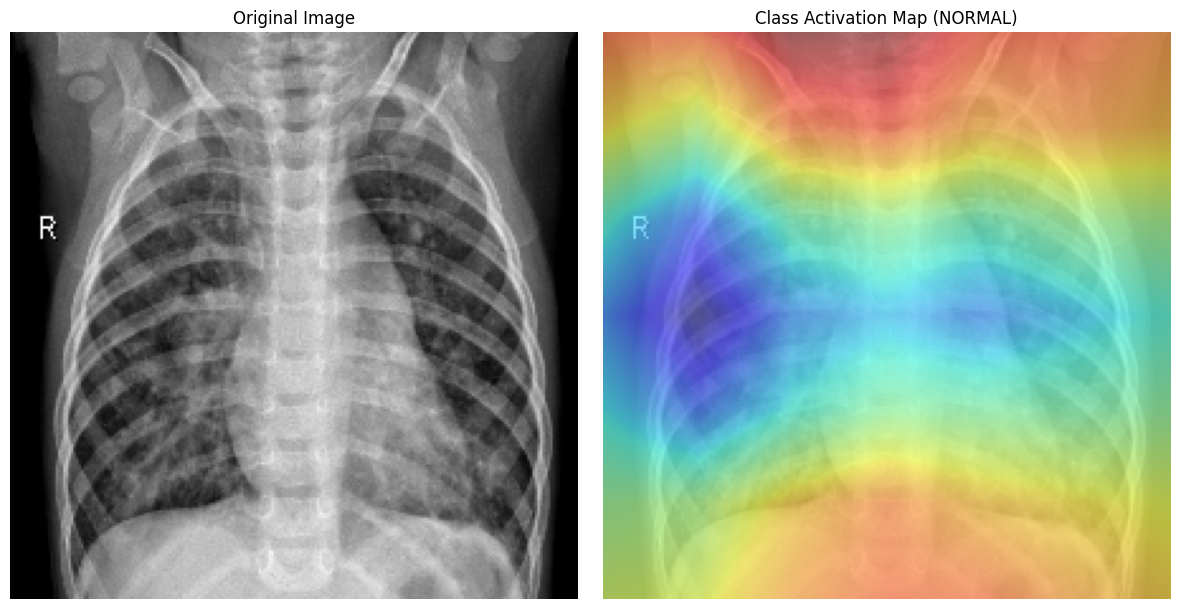

예측 결과: [[0.91859144 0.08140858]]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.vgg16 import preprocess_input  # 또는 해당 모델에 맞는 preprocess_input
import os

# 데이터셋 루트 경로
BASE_PATH = '/content/chest_xray'

# 저장된 모델 로드
try:
    model = load_model('model.keras')
except FileNotFoundError:
    print("오류: 'model.keras' 파일을 찾을 수 없습니다. 학습된 모델 파일의 경로를 확인해주세요.")
    exit()

# CAM 시각화를 위한 새로운 모델 정의 (GAP 이전 컨볼루션 레이어와 최종 출력)
try:
    last_conv_layer = model.get_layer(index=-5)  # MobileNetV2의 경우 이 인덱스는 조정될 수 있습니다.
    cam_model = Model(inputs=model.input, outputs=(last_conv_layer.output, model.output))
except ValueError:
    print("오류: CAM 시각화를 위한 레이어를 찾을 수 없습니다. 모델 구조를 확인해주세요.")
    exit()

# 시각화할 이미지 파일 경로 (이번에는 또 다른 폐렴 이미지로 변경)
img_path = os.path.join(BASE_PATH, 'test/PNEUMONIA/person15_virus_46.jpeg')

try:
    test_img = img_to_array(load_img(img_path, target_size=(224, 224)))
except FileNotFoundError:
    print(f"오류: 이미지 파일을 찾을 수 없습니다: {img_path}")
    exit()

test_input = preprocess_input(np.expand_dims(test_img.copy(), axis=0))

# CAM 모델로 예측
last_conv_output, pred = cam_model.predict(test_input)

# 마지막 컨볼루션 레이어 출력 형태 조정
last_conv_output = np.squeeze(last_conv_output)  # (7, 7, 1280) (MobileNetV2 기준)

# 특징 활성화 맵을 이미지 크기로 확대
feature_activation_maps = scipy.ndimage.zoom(last_conv_output, (32, 32, 1), order=1)  # (7, 7, 1280) -> (224, 224, 1280)

# 예측 클래스 확인 (이전 학습의 클래스 순서에 따라 조정)
pred_class = np.argmax(pred)  # 예: 0: NORMAL, 1: PNEUMONIA
class_names = ['NORMAL', 'PNEUMONIA']  # 실제 클래스 이름으로 변경

# CAM 계산을 위한 가중치 추출 (GAP 레이어 다음 Dense 레이어의 가중치)
try:
    gap_idx = -2  # GlobalAveragePooling2D 레이어의 인덱스 (모델 구조에 따라 조정)
    dense_idx = -1  # 최종 Dense 레이어의 인덱스
    predicted_class_weights = model.layers[dense_idx].get_weights()[0][:, pred_class]  # (1280,)
except IndexError:
    print("오류: CAM 계산을 위한 가중치를 추출하는 데 실패했습니다. 모델 구조를 확인해주세요.")
    exit()

# 최종 CAM 출력 계산
final_output = np.dot(feature_activation_maps.reshape((224 * 224, 1280)), predicted_class_weights).reshape((224, 224))

# 원본 이미지와 CAM을 나란히 시각화
plt.figure(figsize=(12, 6))

# 원본 이미지 표시
plt.subplot(1, 2, 1)
plt.imshow(test_img.astype(np.uint8), cmap='gray')  # 흉부 X-ray는 일반적으로 흑백
plt.title('Original Image')
plt.axis('off')

# CAM 표시
plt.subplot(1, 2, 2)
plt.imshow(test_img.astype(np.uint8), cmap='gray', alpha=0.5)  # 원본 이미지 반투명하게 표시
plt.imshow(final_output, cmap='jet', alpha=0.5)  # CAM을 'jet' 컬러맵으로 overlay
plt.title(f'Class Activation Map ({class_names[pred_class]})')
plt.axis('off')

plt.tight_layout()  # 서브플롯 간 간격 조정
plt.show()

print("예측 결과:", pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


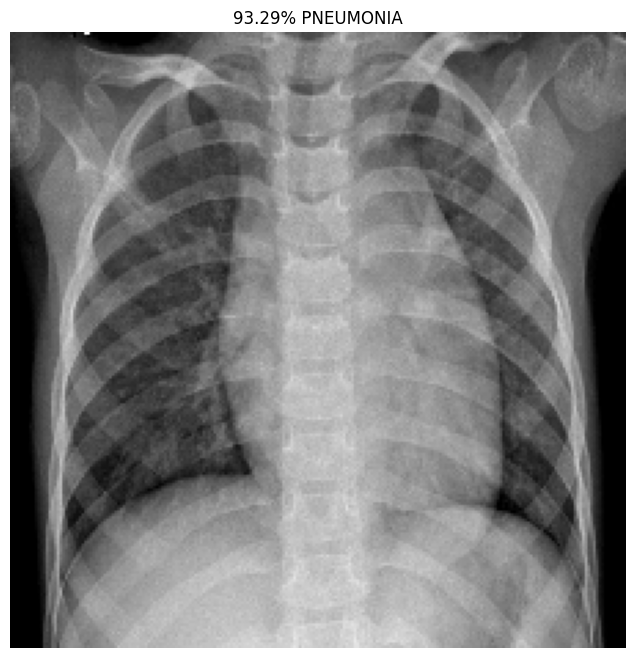

예측 결과: [[0.06705856 0.93294144]]


In [ ]:
# 데이터셋 루트 경로로 BASE_PATH 수정
BASE_PATH = '/content/chest_xray'

# 저장된 모델 로드
try:
    model = load_model('model.keras')
except FileNotFoundError:
    print("오류: 'model.keras' 파일을 찾을 수 없습니다. 학습된 모델 파일의 경로를 확인해주세요.")
    exit()

# 예측할 이미지 파일 경로
img_path = os.path.join(BASE_PATH, 'test/NORMAL/NORMAL2-IM-0359-0001.jpeg') # 예시 이미지 경로 (실제 NORMAL 이미지로 변경)
# 또는
# img_path = os.path.join(BASE_PATH, 'test/PNEUMONIA/person101_bacteria_485.jpeg') # 예시 이미지 경로 (실제 PNEUMONIA 이미지로 변경)

# 위 주석 처리된 부분을 풀고, 실제 예측하고 싶은 이미지 경로로 수정해주세요.
# 현재 코드는 'Free' 또는 'Full' 폴더가 아닌 'test/NORMAL' 폴더의 이미지를 예시로 사용합니다.

try:
    test_img = img_to_array(load_img(img_path, target_size=(224, 224)))
except FileNotFoundError:
    print(f"오류: 이미지 파일을 찾을 수 없습니다: {img_path}")
    exit()

# 모델 입력 형태로 전처리
test_input = preprocess_input(np.expand_dims(test_img.copy(), axis=0))

# 예측 수행
pred = model.predict(test_input)

# 예측 결과 해석 및 시각화
plt.figure(figsize=(8, 8))
plt.imshow(test_img.astype(np.uint8))
plt.axis('off') # 축 숨기기

# 모델이 학습한 클래스 순서에 따라 결과 해석
# 이전 학습 코드에서 classes=['NORMAL', 'PNEUMONIA']로 설정했다면
if pred[0][0] > pred[0][1]:
    plt.title(f'%.2f%% NORMAL' % (pred[0][0] * 100))
else:
    plt.title(f'%.2f%% PNEUMONIA' % (pred[0][1] * 100))

plt.show()

print("예측 결과:", pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


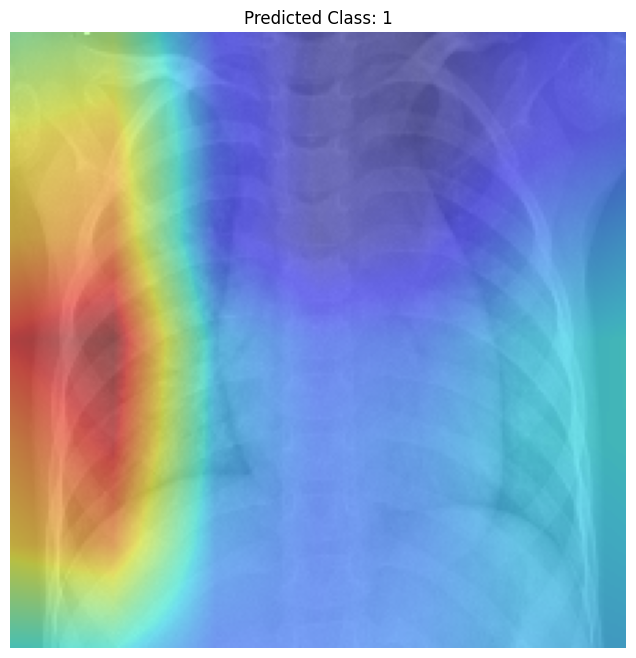

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.vgg16 import preprocess_input # 또는 해당 모델에 맞는 preprocess_input
import os

# 데이터셋 루트 경로
BASE_PATH = '/content/chest_xray'

# 저장된 모델 로드
try:
    model = load_model('model.keras')
except FileNotFoundError:
    print("오류: 'model.keras' 파일을 찾을 수 없습니다. 학습된 모델 파일의 경로를 확인해주세요.")
    exit()

# CAM 시각화를 위한 새로운 모델 정의 (GAP 이전 컨볼루션 레이어와 최종 출력)
try:
    last_conv_layer = model.get_layer(index=-5) # MobileNetV2의 경우 이 인덱스는 조정될 수 있습니다.
    cam_model = Model(inputs=model.input, outputs=(last_conv_layer.output, model.output))
except ValueError:
    print("오류: CAM 시각화를 위한 레이어를 찾을 수 없습니다. 모델 구조를 확인해주세요.")
    exit()

# 예측할 이미지 파일 경로 (이전 단계와 동일한 이미지 사용)
#img_path = os.path.join(BASE_PATH, 'test/NORMAL/NORMAL2-IM-0359-0001.jpeg') test/NORMAL/NORMAL2-IM-0251-0001.jpeg# 예시
# 또는
img_path = os.path.join(BASE_PATH, 'test/PNEUMONIA/person101_bacteria_485.jpeg') # 예시

try:
    test_img = img_to_array(load_img(img_path, target_size=(224, 224)))
except FileNotFoundError:
    print(f"오류: 이미지 파일을 찾을 수 없습니다: {img_path}")
    exit()

test_input = preprocess_input(np.expand_dims(test_img.copy(), axis=0))

# CAM 모델로 예측
last_conv_output, pred = cam_model.predict(test_input)

# 마지막 컨볼루션 레이어 출력 형태 조정
last_conv_output = np.squeeze(last_conv_output) # (7, 7, 1280) (MobileNetV2 기준)

# 특징 활성화 맵을 이미지 크기로 확대
feature_activation_maps = scipy.ndimage.zoom(last_conv_output, (32, 32, 1), order=1) # (7, 7, 1280) -> (224, 224, 1280)

# 예측 클래스 확인 (이전 학습의 클래스 순서에 따라 조정)
pred_class = np.argmax(pred) # 예: 0: NORMAL, 1: PNEUMONIA

# CAM 계산을 위한 가중치 추출 (GAP 레이어 다음 Dense 레이어의 가중치)
try:
    gap_idx = -2 # GlobalAveragePooling2D 레이어의 인덱스 (모델 구조에 따라 조정)
    dense_idx = -1 # 최종 Dense 레이어의 인덱스
    predicted_class_weights = model.layers[dense_idx].get_weights()[0][:, pred_class] # (1280,)
except IndexError:
    print("오류: CAM 계산을 위한 가중치를 추출하는 데 실패했습니다. 모델 구조를 확인해주세요.")
    exit()

# 최종 CAM 출력 계산
final_output = np.dot(feature_activation_maps.reshape((224*224, 1280)), predicted_class_weights).reshape((224, 224))

# CAM 시각화
plt.figure(figsize=(8, 8))
plt.imshow(test_img.astype(np.uint8), alpha=0.5) # 원본 이미지 반투명하게 표시
plt.imshow(final_output, cmap='jet', alpha=0.5) # CAM을 'jet' 컬러맵으로 overlay
plt.title(f'Predicted Class: {pred_class}') # 예측 클래스 표시
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


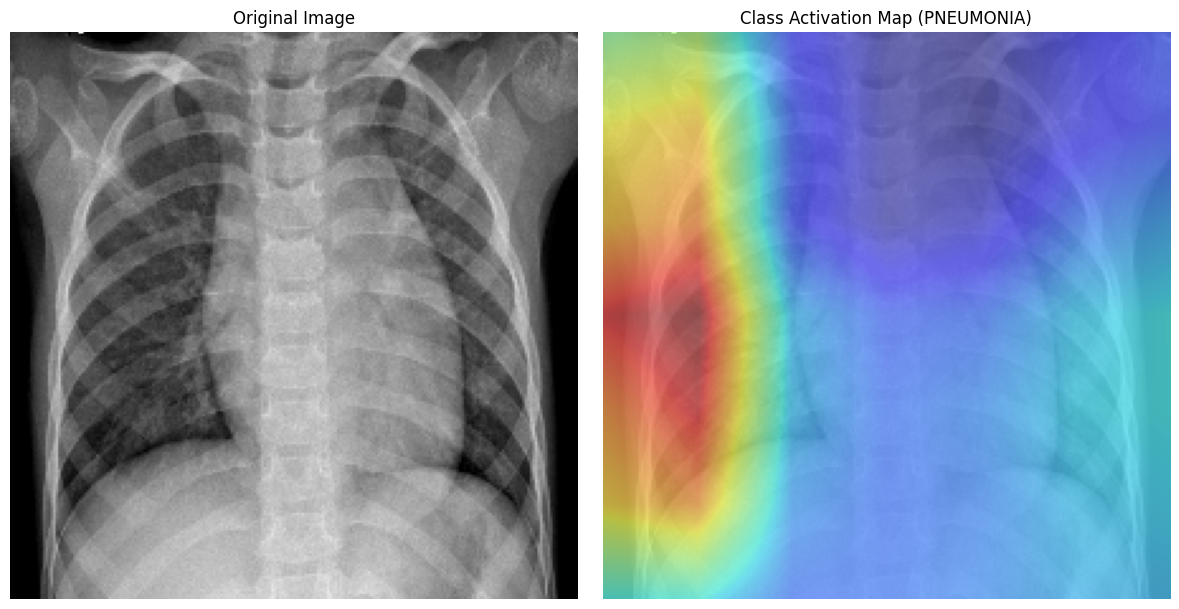

Predicted class: PNEUMONIA (93.29%)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.vgg16 import preprocess_input # 또는 해당 모델에 맞는 preprocess_input
import os

# 데이터셋 루트 경로
BASE_PATH = '/content/chest_xray'

# 저장된 모델 로드
try:
    model = load_model('model.keras')
except FileNotFoundError:
    print("오류: 'model.keras' 파일을 찾을 수 없습니다. 학습된 모델 파일의 경로를 확인해주세요.")
    exit()

# CAM 시각화를 위한 새로운 모델 정의 (GAP 이전 컨볼루션 레이어와 최종 출력)
try:
    last_conv_layer = model.get_layer(index=-5) # MobileNetV2의 경우 이 인덱스는 조정될 수 있습니다.
    cam_model = Model(inputs=model.input, outputs=(last_conv_layer.output, model.output))
except ValueError:
    print("오류: CAM 시각화를 위한 레이어를 찾을 수 없습니다. 모델 구조를 확인해주세요.")
    exit()

# 예측할 이미지 파일 경로 (이전 단계와 동일한 이미지 사용)
#img_path = os.path.join(BASE_PATH, 'test/NORMAL/NORMAL2-IM-0359-0001.jpeg') # 예시
# 또는
img_path = os.path.join(BASE_PATH, 'test/PNEUMONIA/person101_bacteria_485.jpeg') # 예시

try:
    test_img = img_to_array(load_img(img_path, target_size=(224, 224)))
except FileNotFoundError:
    print(f"오류: 이미지 파일을 찾을 수 없습니다: {img_path}")
    exit()

test_input = preprocess_input(np.expand_dims(test_img.copy(), axis=0))

# CAM 모델로 예측
last_conv_output, pred = cam_model.predict(test_input)

# 마지막 컨볼루션 레이어 출력 형태 조정
last_conv_output = np.squeeze(last_conv_output) # (7, 7, 1280) (MobileNetV2 기준)

# 특징 활성화 맵을 이미지 크기로 확대
feature_activation_maps = scipy.ndimage.zoom(last_conv_output, (32, 32, 1), order=1) # (7, 7, 1280) -> (224, 224, 1280)

# 예측 클래스 확인 (이전 학습의 클래스 순서에 따라 조정)
pred_class = np.argmax(pred) # 예: 0: NORMAL, 1: PNEUMONIA
class_names = ['NORMAL', 'PNEUMONIA'] # 실제 클래스 이름으로 변경

# CAM 계산을 위한 가중치 추출 (GAP 레이어 다음 Dense 레이어의 가중치)
try:
    gap_idx = -2 # GlobalAveragePooling2D 레이어의 인덱스 (모델 구조에 따라 조정)
    dense_idx = -1 # 최종 Dense 레이어의 인덱스
    predicted_class_weights = model.layers[dense_idx].get_weights()[0][:, pred_class] # (1280,)
except IndexError:
    print("오류: CAM 계산을 위한 가중치를 추출하는 데 실패했습니다. 모델 구조를 확인해주세요.")
    exit()

# 최종 CAM 출력 계산
final_output = np.dot(feature_activation_maps.reshape((224*224, 1280)), predicted_class_weights).reshape((224, 224))

# 원본 이미지와 CAM을 나란히 시각화
plt.figure(figsize=(12, 6))

# 원본 이미지 표시
plt.subplot(1, 2, 1)
plt.imshow(test_img.astype(np.uint8))
plt.title('Original Image')
plt.axis('off')

# CAM 표시
plt.subplot(1, 2, 2)
plt.imshow(test_img.astype(np.uint8), alpha=0.5) # 원본 이미지 반투명하게 표시
plt.imshow(final_output, cmap='jet', alpha=0.5) # CAM을 'jet' 컬러맵으로 overlay
plt.title(f'Class Activation Map ({class_names[pred_class]})')
plt.axis('off')

plt.tight_layout() # 서브플롯 간 간격 조정
plt.show()
print(f"Predicted class: {class_names[pred_class]} ({pred[0][pred_class]*100:.2f}%)")